In [1]:
import os
import pickle
import re

import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from folium.plugins import TimestampedGeoJson
from geopy.distance import geodesic

In [2]:
locations_list = [
    [55.539306, 051.856451],    # д. Клятле
    [55.622944, 051.825578],    # ул. Ахтубинская, 4б
    [55.650091, 051.852687],    # ул. Гагарина, 32
    [55.598983, 051.771936],    # ул. Юбилейная, 3
    [55.613193, 051.784821],    # ул. Южная, 3
    [55.654578, 051.800072]     # ул. Ямьле, 20
]

### Промышленные объекты и их координаты  
https://fabricators.ru/zavody/nizhnekamsk  
https://xn--80aegj1b5e.xn--p1ai/factories/nizhnekamsk

In [3]:
plants_list = [
    # lat, lon
    [55.577916, 51.829092],    # Камский завод полимерных материалов
    [55.580406, 51.832423],    # Нижнекамский завод металлических конструкций
    [55.600826, 52.006558],    # Нижнекамсктехуглерод
    [55.611971, 51.949400],    # Нижнекамскнефтехим (завод Этилен)
    [55.607269, 51.918995],    # Промзона 1_1
    [55.596030, 51.916050],    # Промзона 1_2
    [55.608176, 51.950205],    # Промзона 2_1
    [55.594242, 51.953988],    # Промзона 2_2
    [55.611434, 51.968755],    # Нижнекамскшина (массовые шины)
    [55.611325, 51.984527],    # Нижнекамскшина (грузовые шины)
    [55.568804, 51.887739],    # Таиф-НК, завод бензинов
    [55.590493, 51.943682],    # Таиф-НК, комплекс глубокой переработки нефти
    [55.595089, 51.808537],    # Камасталь
    [55.567365, 51.909208],    # Танеко
    [55.604712, 51.963051],    # Завод Эластик
    [55.602338, 51.808578],    # Криоген-НК
    [55.602188, 51.844907],    # Камэнергостройпром
  # [55.612118, 51.975523],    # Нижнекамский механический завод
    ]
plants_dict = {
    "Камский завод полимерных материалов": [55.577916, 51.829092],
    "Нижнекамский завод металлических конструкций": [55.580406, 51.832423],
    "Нижнекамсктехуглерод": [55.600826, 52.006558],
    "Нижнекамскнефтехим (завод Этилен)": [55.611971, 51.949400],
    "Промзона 1_1": [55.607269, 51.918995],
    "Промзона 1_2": [55.596030, 51.916050],
    "Промзона 2_1": [55.608176, 51.950205],
    "Промзона 2_2": [55.594242, 51.953988],
    "Нижнекамскшина (массовые шины)": [55.611434, 51.968755],
    "Нижнекамскшина (грузовые шины)": [55.611325, 51.984527],
    "Таиф-НК, завод бензинов": [55.568804, 51.887739],
    "Таиф-НК, комплекс глубокой переработки нефти": [55.590493, 51.943682],
    "Камасталь": [55.595089, 51.808537],
    "Танеко": [55.567365, 51.909208],
    "Завод Эластик": [55.604712, 51.963051],
    "Криоген-НК": [55.602338, 51.808578],
    "Камэнергостройпром": [55.602188, 51.844907]
}

### Карта производств

In [4]:
plants_map = folium.Map(location=[55.596030, 51.916050], zoom_start = 11.5)

# Добавление маркеров
for coordinates in plants_list:
    folium.Circle(
        radius=40,
        location=coordinates,
        # popup = marker,
        color='gray',
        fill=True,
        fill_opacity=1
    ).add_to(plants_map)

plants_map.save("../app/templates/plants_map.html")
plants_map

## Инференс  
по данным, на которых обучались модели

In [5]:
# Функция для преобразования формата скорости ветра
def extract_value(value):
    if isinstance(value, (int, float)):
        return value
    match = re.search(r'\((\d+\.\d+)\)', str(value))
    if match:
        return float(match.group(1))
    return value


# Функция загрузки и подготовки данных по нужным веществам из всех 6 геоточек
def load_data(file, all_substances, meteo_params):
    """file - файл с данными для определенной геоточки
       all_substances - названия загрязняющих веществ
    """

    point = pd.read_excel(os.path.join(path, file))
    # Обработка индексов строк и столбцов
    indexes = list(point.loc[0])
    indexes = indexes[1:]
    point = point.loc[3:].set_index('Интервал отбора')
    point.index = pd.to_datetime(point.index, format='%d.%m.%Y %H:%M')
    point.index = point.index.strftime('%Y-%m-%d %H:%M')   # добавлена работа с date
    point.columns = indexes

    point = point.apply(lambda x: x.str.replace(',', '.'))
    point['V ветра, м/с'] = point['V ветра, м/с'].apply(extract_value)
    point[['Угол ветра, °', 'Направление ветра']] = point['D ветра, °'].str.extract(r'(\d+)\s?\((.+)\)')
    point['Направление ветра'].replace(np.NaN, 'Ш', inplace=True)

    # Пересечение множеств названий столбцов и substances
    substances = set(indexes) & set(all_substances)
    columns = [*substances, *meteo_params]
    point = point[columns]

    # Заполнение пропусков, если их в столбце не более 5%
    for col in point.columns:
        point[col] = pd.to_numeric(point[col], errors='ignore')
        if point[col].isna().sum().sum() / len(point) < 0.05:
            point[col].interpolate(inplace=True)

    return point

def melt_columns(df, substances, Mr, meteo_params):
    """Функция 'расплавления' столбцов с веществами"""

    df = pd.melt(df, id_vars=meteo_params, ignore_index=False)

    # Закодируем названия веществ их молекулярной массой
    df.replace(substances, Mr, inplace=True)
    df.rename(columns={"variable": "Mr", "value": "C, мг/м³"}, inplace=True)

    df["Mr"] = pd.to_numeric(df["Mr"], errors='coerce')

    return df

In [6]:
meteo_params = ['T внеш., °C',
                'P атм., мм.рт.ст.',
                'V ветра, м/с',
                'Угол ветра, °',
                'Направление ветра'
                ]
# Загрязнители в алфавитном порядке
substances = ['CO, мг/м³',
              'H2S, мг/м³',
              'NH3, мг/м³',
              'NO, мг/м³',
              'NO2, мг/м³',
              'SO2, мг/м³'
              ]
# Молекулярные массы веществ из substances
Mr = [28, 30, 46, 17, 64, 34]

# Временной лаг
lags = 4

In [7]:
# Директория с данными
path = '../data/raw'
files = os.listdir(path)
os.listdir(path)

['test',
 'Усредненные_данные_Нижнекамск_т.1.xlsx',
 'Усредненные_данные_Нижнекамск_т.2.xlsx',
 'Усредненные_данные_Нижнекамск_т.3.xlsx',
 'Усредненные_данные_Нижнекамск_т.4.xlsx',
 'Усредненные_данные_Нижнекамск_т.5.xlsx',
 'Усредненные_данные_Нижнекамск_т.6.xlsx']

### Загрузка и обработка входных данных  
Проверим вычисление концентраций для одного из контрольных пунктов. Подадим в модель часть данных из д. Клятле, в которые произошел выброс SO2.

In [8]:
points = [load_data(file, substances, meteo_params) for file in files if file.endswith('.xlsx')]
points[0].head()    # д. Клятле

,"CO, мг/м³","H2S, мг/м³","NH3, мг/м³","SO2, мг/м³","NO2, мг/м³","NO, мг/м³","T внеш., °C","P атм., мм.рт.ст.","V ветра, м/с","Угол ветра, °",Направление ветра
Интервал отбора,,,,,,,,,,,
2023-06-01 00:00,0.2,0.0004,0.014,0.003,0.001,0.001,16.8,745.1,0.2,106.0,В
2023-06-01 00:30,0.2,0.0004,0.014,0.003,0.001,0.002,15.8,745.1,0.3,106.0,В
2023-06-01 01:00,0.2,0.0006,0.014,0.002,0.002,0.002,15.3,745.0,0.1,107.0,В
2023-06-01 01:30,0.2,0.0005,0.014,0.003,0.001,0.002,14.8,745.1,0.0,NaN,Ш
2023-06-01 02:00,0.2,0.0005,0.015,0.003,0.001,0.002,15.2,745.2,0.4,134.0,Ю-В


In [9]:
df_melted_list = [melt_columns(df, substances, Mr, meteo_params) for df in points]

In [10]:
df_melted_list[0].head()

,"T внеш., °C","P атм., мм.рт.ст.","V ветра, м/с","Угол ветра, °",Направление ветра,Mr,"C, мг/м³"
Интервал отбора,,,,,,,
2023-06-01 00:00,16.8,745.1,0.2,106.0,В,28,0.2
2023-06-01 00:30,15.8,745.1,0.3,106.0,В,28,0.2
2023-06-01 01:00,15.3,745.0,0.1,107.0,В,28,0.2
2023-06-01 01:30,14.8,745.1,0.0,NaN,Ш,28,0.2
2023-06-01 02:00,15.2,745.2,0.4,134.0,Ю-В,28,0.2


In [11]:
# ничего не менялось
def make_df(df, num, target_num, lags=None):
    """Функция предобработки датасета с предикторами
       num - номер геоточки
       target_num - номер точки, в которой модель будет считать концентрацию
    """

    coor = locations_list[num - 1]
    target_coor = locations_list[target_num - 1]

    df = df.copy()
    df.dropna(inplace=True)
    df['lat'], df['lon'] = coor

    # Добавим расстояние от данной точки до точки c target_coor в качестве входной переменной
    df['distance, km'] = geodesic(coor, target_coor).km

    # Фичи c временными лагам
    if lags:
        for i in range(1, lags):
            df[f"T внеш_{i}"] = df['T внеш., °C'].shift(i)
            df[f"P атм._{i}"] = df['P атм., мм.рт.ст.'].shift(i)
            df[f"V ветра_{i}"] = df['V ветра, м/с'].shift(i)
            df[f"Угол ветра_{i}"] = df['Угол ветра, °'].shift(i)
            df[f"C, мг/м³_{i}"] = df['C, мг/м³'].shift(i)
    df.dropna(inplace=True)

    return df

# переименована переменная target_num
def concat_dfs(df_melted_list, target_num, lags=5):
    X_list = [make_df(df, i + 1, target_num, lags) for i, df in enumerate(df_melted_list)]
    del X_list[target_num - 1]  # сопоставление точки самой с собой
    X_num = pd.concat(X_list, axis=0)
    return X_num

In [12]:
# Вычисляем расстояния из всех контрольных пунктов до выбранной точки (т.1, Клятле)
X = concat_dfs(df_melted_list, 1, lags)
X.dropna(inplace=True)
X = pd.get_dummies(X, columns=['Направление ветра'])

In [13]:
# Рассчитаем прогноз только для SO2
for substance in ['SO2, мг/м³']:
    catboost = pickle.load(open(f'../app/ml_models/model_{substance[:3]}.pkl', 'rb'))
    pred = catboost.predict(X)
    print((pred < 0).sum(), 'отрицательных значений заменены на 0')
    pred[pred < 0] = 0

    # Отсортируем значения по времени
    pred = pd.Series(pred, index=X.index)
    pred_sorted = pred.sort_index()

838 отрицательных значений заменены на 0


In [14]:
# Отберем значения для графика
pred_plot = pred_sorted[500:2700]
# Реальные значения по SO2
real = points[0][substance]
real_plot = real.loc[real.index.isin(pred_plot.index)]

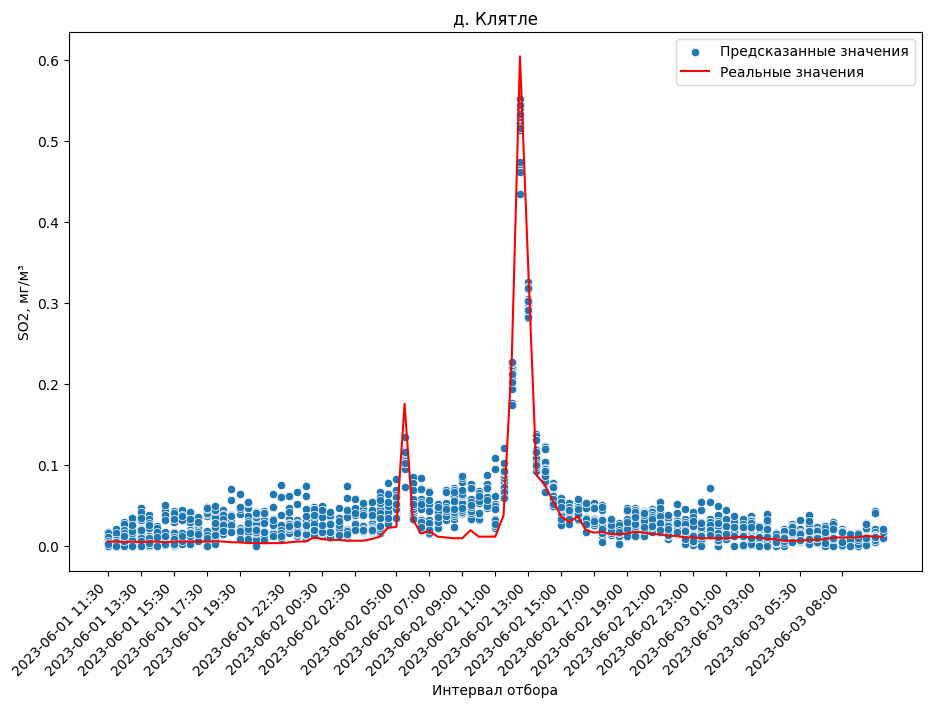

In [15]:
plt.figure(figsize=(11, 7))
ax = sns.scatterplot(data=pred_plot, label='Предсказанные значения')
real_plot.plot(ax=ax, label='Реальные значения', color='red')
x_labels = pred_plot.index
ax.set_xticks(x_labels[::100])
ax.set_xticklabels(x_labels[::100], rotation=45, ha="right")
ax.set_ylabel(substance)
plt.title('д. Клятле')
plt.legend()
plt.show()

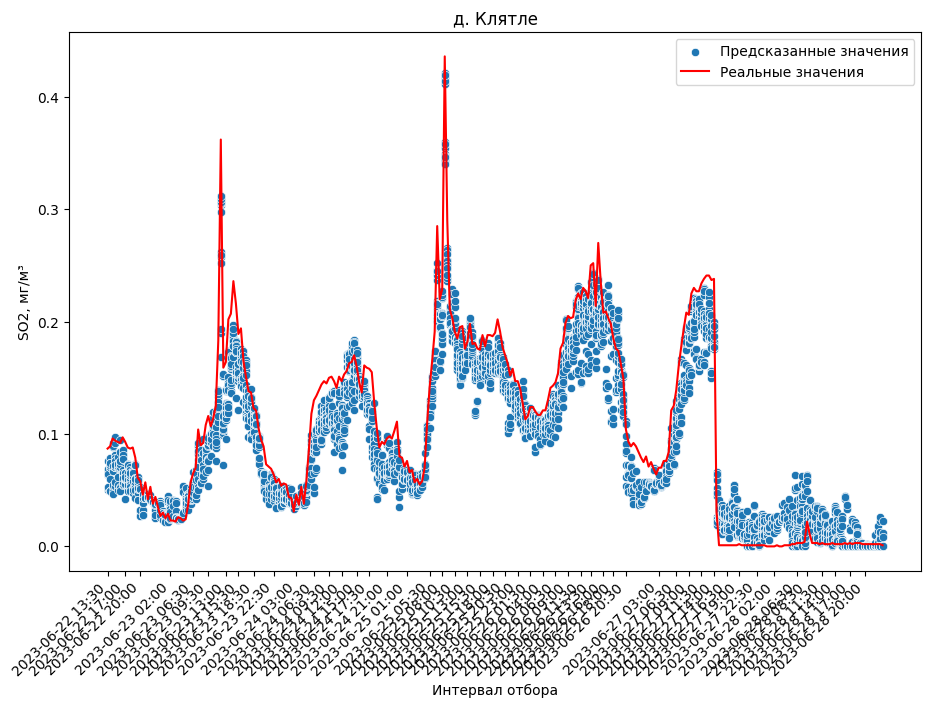

In [16]:
# Отберем значения для графика
pred_plot = pred_sorted[20000:25000]
real = points[0][substance]
real_plot = real.loc[real.index.isin(pred_plot.index)]

plt.figure(figsize=(11, 7))
ax = sns.scatterplot(data=pred_plot, label='Предсказанные значения')
real_plot.plot(ax=ax, label='Реальные значения', color='red')
x_labels = pred_plot.index
ax.set_xticks(x_labels[::100])
ax.set_xticklabels(x_labels[::100], rotation=45, ha="right")
ax.set_ylabel(substance)
plt.title('д. Клятле')
plt.legend()
plt.show()

Сейчас одному моменту времени соответствует несколько предсказанных значений, так как прогнозы делаются по данным из нескольких мест и на основании уровня различных веществ в этих местах. Поскольку для нас важно не пропустить появление повышенных концентраций, выберем для одного индекса времени только максимальное предсказанное значение.

In [17]:
# Максимальные из предсказанных значений
max_pred = pred_sorted.groupby(level=0).max()

In [18]:
from sklearn.metrics import mean_absolute_error
print('MAE =', mean_absolute_error(max_pred, real))

MAE = 0.01747497268824911


Отладим вычисление концентраций для одной из точек с предприятием на примере **Промзоны 1_1**

In [19]:
target_location = plants_list[4]
print('Координаты Промзоны 1_1')
target_location

Координаты Промзоны 1_1


[55.607269, 51.918995]

In [20]:
points = [load_data(file, substances, meteo_params) for file in files if file.endswith('.xlsx')]
df_melted_list = [melt_columns(df, substances, Mr, meteo_params) for df in points]

In [21]:
def make_df(df, num, target_num, lags=None):
    """Функция предобработки датасета с предикторами
       num - номер геоточки
       target_num - номер точки, в которой модель будет считать концентрацию
    """

    coor = locations_list[num - 1]
    target_coor = plants_list[target_num - 1]   # изменился список координат
    
    df = df.copy()
    df.dropna(inplace=True)
    df['lat'], df['lon'] = coor

    # Добавим расстояние от данной точки до точки c target_coor в качестве входной переменной
    df['distance, km'] = geodesic(coor, target_coor).km

    # Фичи c временными лагам
    if lags:
        for i in range(1, lags):
            df[f"T внеш_{i}"] = df['T внеш., °C'].shift(i)
            df[f"P атм._{i}"] = df['P атм., мм.рт.ст.'].shift(i)
            df[f"V ветра_{i}"] = df['V ветра, м/с'].shift(i)
            df[f"Угол ветра_{i}"] = df['Угол ветра, °'].shift(i)
            df[f"C, мг/м³_{i}"] = df['C, мг/м³'].shift(i)
    df.dropna(inplace=True)

    return df

In [22]:
def concat_dfs(df_melted_list, target_num, lags=5):
    X_list = [make_df(df, i + 1, target_num, lags) for i, df in enumerate(df_melted_list)]
    # del X_list[target_num - 1]  # сопоставление точки самой с собой
    X_num = pd.concat(X_list, axis=0)
    return X_num

In [23]:
# Вычисляем расстояния из всех контрольных пунктов до предприятия
X = concat_dfs(df_melted_list, 4 + 1, lags)
X.dropna(inplace=True)
X = pd.get_dummies(X, columns=['Направление ветра'])
X.head()

,"T внеш., °C","P атм., мм.рт.ст.","V ветра, м/с","Угол ветра, °",Mr,"C, мг/м³",lat,lon,"distance, km",T внеш_1,...,"C, мг/м³_3",Направление ветра_В,Направление ветра_З,Направление ветра_С,Направление ветра_С-В,Направление ветра_С-З,Направление ветра_Ш,Направление ветра_Ю,Направление ветра_Ю-В,Направление ветра_Ю-З
Интервал отбора,,,,,,,,,,,,,,,,,,,,,
2023-06-01 02:00,15.2,745.2,0.4,134.0,28,0.2,55.539306,51.856451,8.533335,15.3,...,0.2,False,False,False,False,False,False,False,True,False
2023-06-01 02:30,16.4,745.1,0.9,157.0,28,0.2,55.539306,51.856451,8.533335,15.2,...,0.2,False,False,False,False,False,False,False,True,False
2023-06-01 03:00,17.0,745.1,2.1,163.0,28,0.2,55.539306,51.856451,8.533335,16.4,...,0.2,False,False,False,False,False,False,True,False,False
2023-06-01 03:30,17.4,745.4,2.3,206.0,28,0.2,55.539306,51.856451,8.533335,17.0,...,0.2,False,False,False,False,False,False,False,False,True
2023-06-01 04:00,17.6,745.5,2.3,229.0,28,0.2,55.539306,51.856451,8.533335,17.4,...,0.2,False,False,False,False,False,False,False,False,True


In [24]:
# Загрузка моделей для определения каждого вещества
for substance in substances:
    print(f'../app/ml_models/model_{substance[:3]}.pkl')

../app/ml_models/model_CO,.pkl
../app/ml_models/model_H2S.pkl
../app/ml_models/model_NH3.pkl
../app/ml_models/model_NO,.pkl
../app/ml_models/model_NO2.pkl
../app/ml_models/model_SO2.pkl


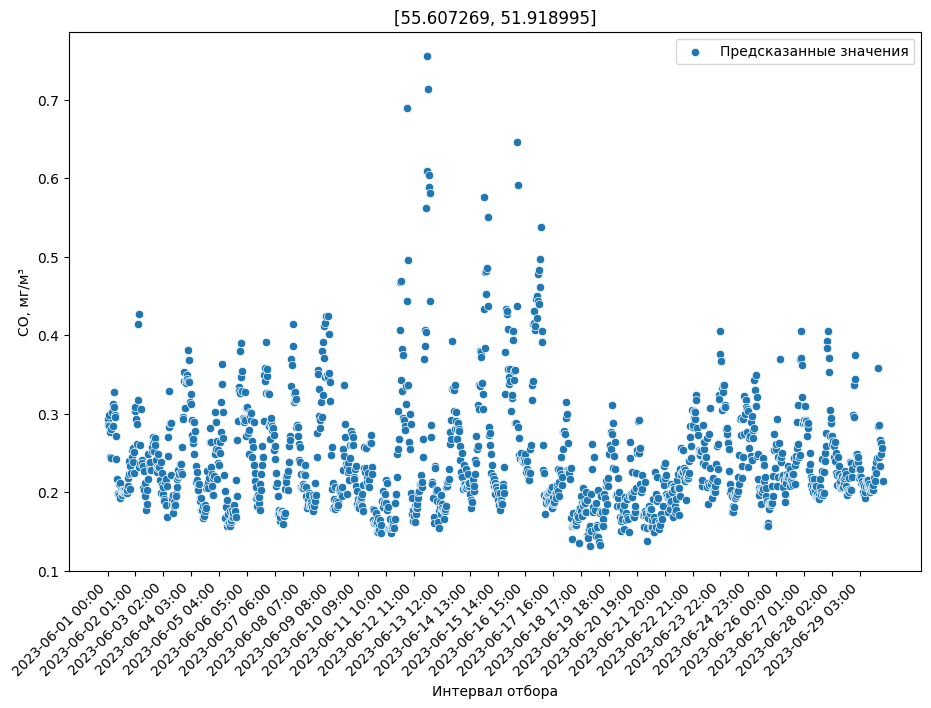

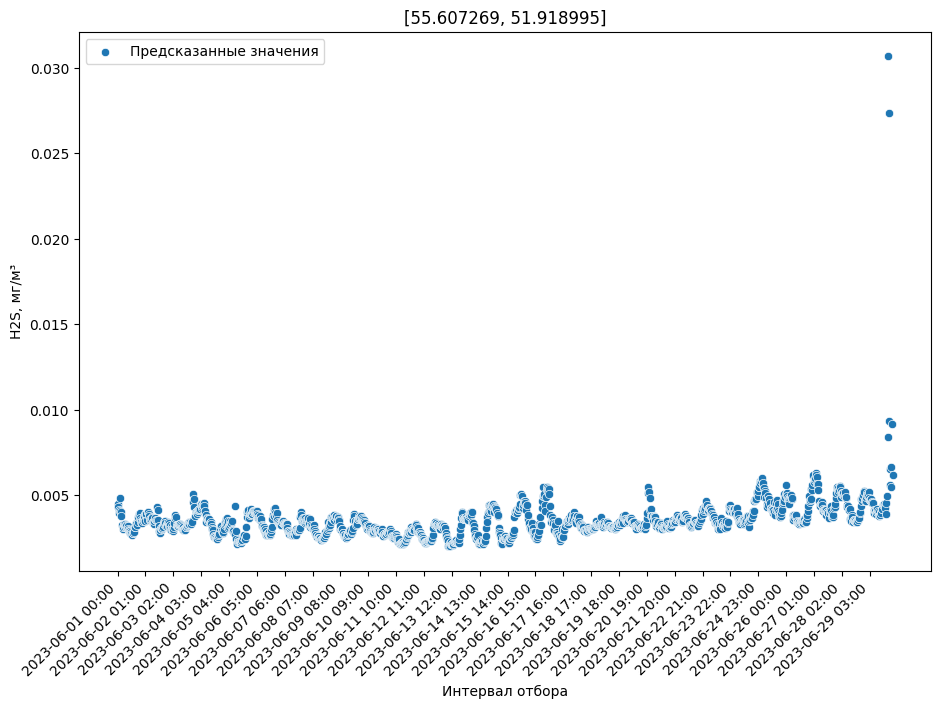

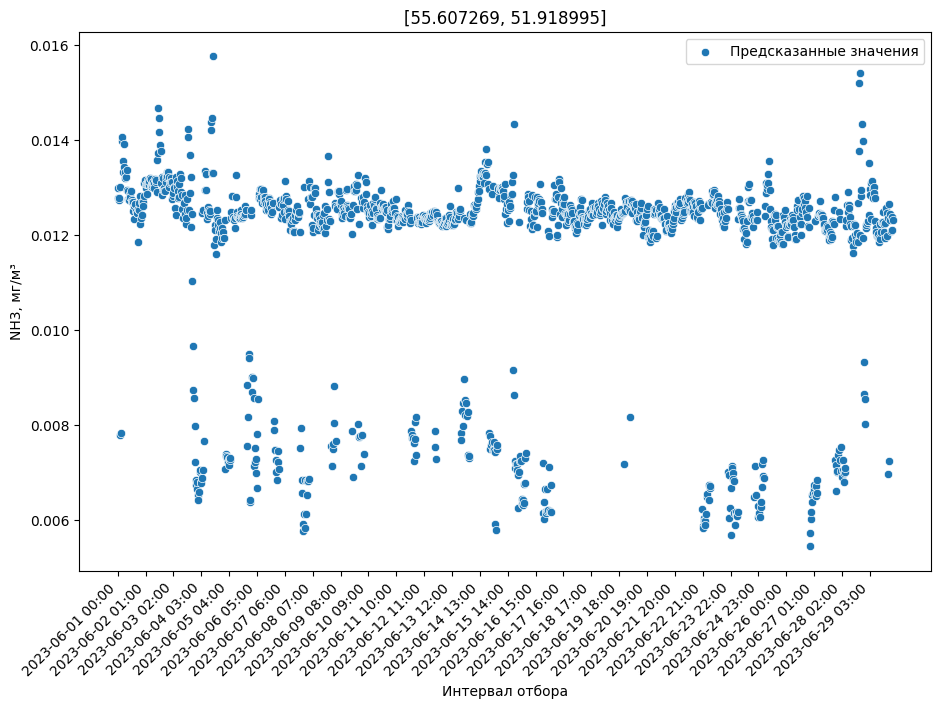

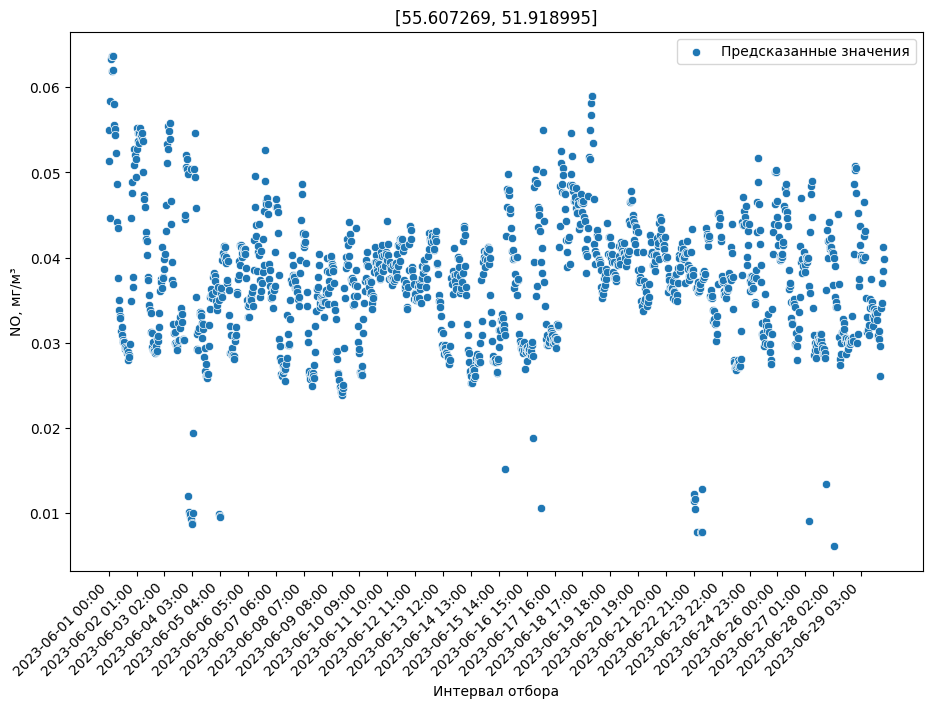

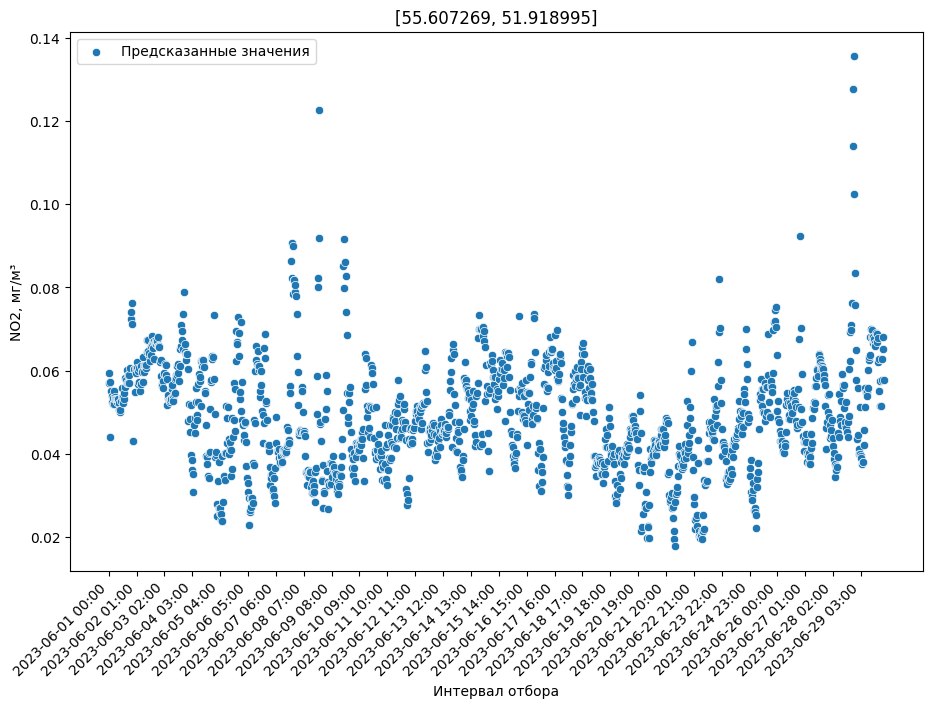

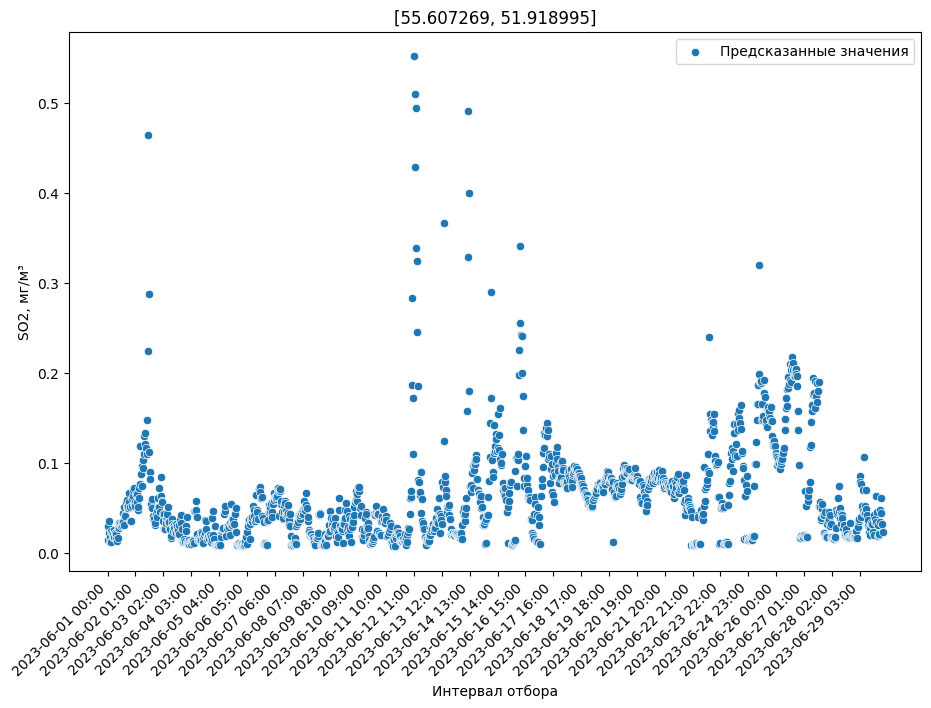

In [25]:
for substance in substances:

    catboost = pickle.load(open(f'../app/ml_models/model_{substance[:3]}.pkl', 'rb'))
    pred = catboost.predict(X)
    
    # Замена отрицательных значений
    pred[pred < 0] = 0
    # Сортировка значений по времени
    pred = pd.Series(pred, index=X.index)
    pred_sorted = pred.sort_index()
    # Максимальные из предсказанных значений
    max_pred = pred_sorted.groupby(level=0).max()
    
    # График
    plt.figure(figsize=(11, 7))
    ax = sns.scatterplot(data=max_pred, label='Предсказанные значения')
    x_labels = max_pred.index
    ax.set_xticks(x_labels[::50])
    ax.set_xticklabels(x_labels[::50], rotation=45, ha="right")
    ax.set_ylabel(substance)
    plt.title(target_location)
    plt.legend()
    plt.show()
    print()

### Визуализация на карте

Выведем уровни ПДК

In [26]:
point1 = pd.read_excel('../data/raw/Усредненные_данные_Нижнекамск_т.1.xlsx')
threshold = dict(zip(point1.iloc[0, 2:].values, point1.iloc[0:2, 2:].iloc[1].values))
threshold

{'CO, мг/м³': 5,
 'NO, мг/м³': 0.4,
 'NO2, мг/м³': 0.2,
 'NH3, мг/м³': 0.2,
 'SO2, мг/м³': 0.5,
 'H2S, мг/м³': 0.008,
 'T внеш., °C': '-',
 'V ветра, м/с': '-',
 'D ветра, °': '-',
 'H внеш., %': '-',
 'P атм., мм.рт.ст.': '-',
 'R осадк., мм/ч': '-'}

In [27]:
max_pred.head()

Интервал отбора
2023-06-01 00:00    0.030074
2023-06-01 00:30    0.013941
2023-06-01 01:00    0.035387
2023-06-01 01:30    0.021857
2023-06-01 02:00    0.017372
dtype: float64

In [28]:
# Добавить в цикл
# Подговка данных для отображения на карте
data = pd.DataFrame({'prediction': max_pred.round(4)})

In [56]:
def get_color(prediction):
    if prediction <= 0.25:
        return 'gray'
    else:
        return 'red'

def get_radius(prediction):
    if prediction <= 0.25:
        return 3
    else:
        return 10

def get_opacity(prediction):
    if prediction <= 0.25:
        return 1
    else:
        return 0.3

def get_polut_coor(prediction):
    if prediction <= 0.25:
        return [0, -90]   # южный полюс
    else:
        return [plants_dict["Промзона 1_1"][1], plants_dict["Промзона 1_1"][0]]

def get_threshold_coor(prediction):
    if prediction < 0.5:
        return [0, -90]   # южный полюс
    else:
        return [plants_dict["Промзона 1_1"][1], plants_dict["Промзона 1_1"][0]]

# Параметры маркера на карте
data['color'] = data['prediction'].apply(get_color)
data['radius'] = data['prediction'].apply(get_radius)
data['opacity'] = data['prediction'].apply(get_opacity)
data['polut_coor'] = data['prediction'].apply(get_polut_coor)
data['threshold_coor'] = data['prediction'].apply(get_threshold_coor)

In [57]:
data.sample(5)

,prediction,color,radius,opacity,polut_coor,threshold_coor
Интервал отбора,,,,,,
2023-06-23 16:30,0.1357,gray,3,1.0,"[0, -90]","[0, -90]"
2023-06-09 15:30,0.0608,gray,3,1.0,"[0, -90]","[0, -90]"
2023-06-29 11:00,0.0228,gray,3,1.0,"[0, -90]","[0, -90]"
2023-06-19 18:00,0.0784,gray,3,1.0,"[0, -90]","[0, -90]"
2023-06-15 08:30,0.2901,red,10,0.3,"[51.918995, 55.607269]","[0, -90]"


Один маркер для одного момента времени

In [31]:
# plants_map = folium.Map(location=[55.596030, 51.916050], zoom_start = 11.5)

# Подпись маркера
html = f"""
    <p style='color:blue;'>
        {data.index[0]}                 <!-- время -->
    </p>      
    <h2>{substance}</h2>                <!-- вещество -->
    <h3>
    <code>
        {data['prediction'][0]} мг/м3   <!-- концентрация -->
    </code>
    </h3>
    <p> Промзона 1_1 </p>               <!-- предприятие -->
    {plants_dict["Промзона 1_1"]}       <!-- координаты -->
    """

# Маркеры веществ
folium.Marker(
    location=plants_dict["Промзона 1_1"],
    popup = html,
    icon=folium.Icon(color = 'red')
).add_to(plants_map)

plants_map.save("../app/templates/demo_map.html")

**TimeStamp in Folium**  
Визуализация во времени с помощью плагина GeoJson  
https://python-visualization.github.io/folium/latest/user_guide/plugins/timestamped_geojson.html  
https://towardsdatascience.com/visualizing-air-pollution-with-folium-maps-4ce1a1880677

In [32]:
def popup(idx, row):
    popup = f"""
        <p style='color:blue;'>
            {idx}                        <!-- время -->
        </p>      
        <h2>{substance}</h2>             <!-- вещество -->
        <h3>
        <code>
            {row['prediction']} мг/м3    <!-- концентрация -->
        </code>
        </h3>
        <p> Промзона 1_1 </p>             <!-- предприятие -->
        {plants_dict["Промзона 1_1"]}     <!-- координаты -->
        """
    return popup

In [ ]:
features = [
    {
        "type": "Feature",
        "geometry": {
            "type": "Point",
            # меняем местами широту и долготу для GeoJSON
            "coordinates": [plants_dict["Промзона 1_1"][1], plants_dict["Промзона 1_1"][0]]
        },
        "properties": {
            "time": idx,
            "popup": popup(idx, row),
            "style": {"weight": 0},
            "icon": "circle",
            'iconstyle':{
                    'fillColor': row['color'],
                    'fillOpacity': row['opacity'],
                    'stroke': 'false',
                    'radius': row['radius']
                }
        },
    }
    for idx, row in data.iterrows()
]

map_SO2 = folium.Map(
    location=[55.596030, 51.916050], zoom_start = 11.5
)

TimestampedGeoJson(
    {"type": "FeatureCollection", "features": features},
    period="PT30M",    # через 30 мин
    add_last_point=True,
    auto_play=False,
    loop=False,
    max_speed=1,
    loop_button=True,
    date_options="YYYY-MM-DD HH:mm",
    time_slider_drag_update=True,
).add_to(map_SO2)

map_SO2

In [59]:
# Всплывающее окно с информацией
features = [
    {
        "type": "Feature",
        "geometry": {
            "type": "Point",
            # меняем местами широту и долготу для GeoJSON
            "coordinates": [plants_dict["Промзона 1_1"][1], plants_dict["Промзона 1_1"][0]]
        },
        "properties": {
            "time": idx,
            "popup": popup(idx, row),
            "icon": "marker",
            },
    }
    for idx, row in data.iterrows()
]

# Сигнал о повышении концентрации
features.append(
    {
        "type": "Feature",
        "geometry": {
            "type": "LineString",
            "coordinates": list(data['polut_coor']),
        },
        "properties": {
            "times": list(data.index),
            "icon": "circle",
            "iconstyle": {
                "fillColor": "red",
                "fillOpacity": 0.3,
                "radius": 15,
            },
            "style": {"weight": 0},
        },
    }
)

# Сигнал о превышении ПДК
features.append(
    {
        "type": "Feature",
        "geometry": {
            "type": "LineString",
            "coordinates": list(data['threshold_coor']),
        },
        "properties": {
            "times": list(data.index),
            "icon": "circle",
            "iconstyle": {
                "fillColor": "red",
                "fillOpacity": 0.5,
                "radius": 18,
            },
            "style": {"weight": 0},
        },
    }
)

map_SO2 = folium.Map(
    location=[55.596030, 51.916050], zoom_start = 11.5
)

TimestampedGeoJson(
    {"type": "FeatureCollection", "features": features},
    period="PT30M",    # через 30 мин
    add_last_point=True,
    auto_play=False,
    loop=False,
    max_speed=1,
    loop_button=True,
    date_options="YYYY-MM-DD HH:mm",
    time_slider_drag_update=True,
).add_to(map_SO2)

map_SO2

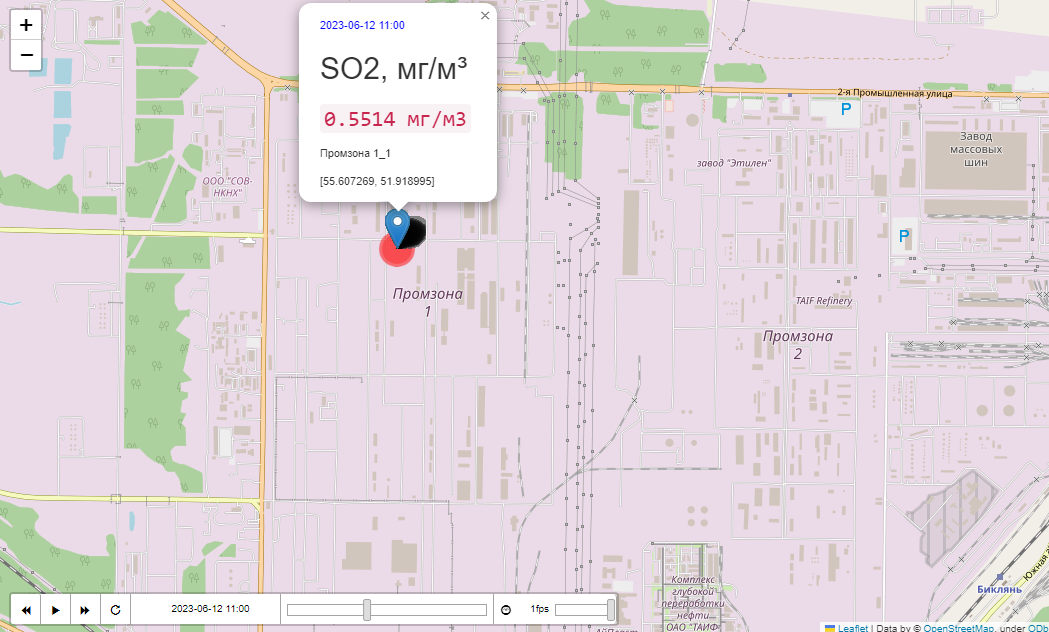